<a href="https://colab.research.google.com/github/kzktds/PetFinder_competition/blob/master/20200518_%E7%94%BB%E5%83%8F%E7%89%B9%E5%BE%B4%E9%87%8F%E3%82%92%E7%94%9F%E6%88%90%E3%81%99%E3%82%8B%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像特徴量を学習済みモデルを用いて抽出するサンプル

In [0]:
import cv2
import pandas as pd
import numpy as np
import os
from tqdm import tqdm, tqdm_notebook

img_size = 256

In [3]:
from keras.applications.resnet50 import preprocess_input, ResNet50

Using TensorFlow backend.


## 画像前処理・読み込み用関数の定義

In [0]:
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

In [0]:
def load_image(path):
    image = cv2.imread(path)
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

## 画像を読み込んで表示

In [0]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


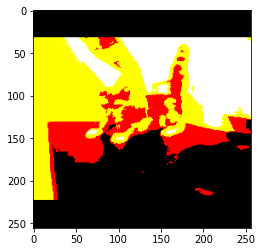

In [7]:
# 前処理済みの画像を試しに出力
img = load_image("/content/drive/My Drive/20200515_マルチモーダル検証/image/cat.0.jpg")
plt.imshow(img)

In [8]:
img.shape

(256, 256, 3)

## 学習済みモデルによる特徴抽出
- 参考：https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn

In [9]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
inp = Input((256,256,3))
backbone = ResNet50(input_tensor = inp, include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


In [0]:
pred = m.predict(np.array([img]))

In [11]:
pred.shape

(1, 512)

In [14]:
pred[0][:5]

array([0.5559616, 0.5559541, 0.0985456, 0.556401 , 0.3798355],
      dtype=float32)

## SVDによる次元圧縮
- https://qiita.com/FukuharaYohei/items/f3d975e7a9a801dd29fc

In [0]:
from sklearn.decomposition import TruncatedSVD

In [0]:
IMAGE_PATH = "/content/drive/My Drive/20200515_マルチモーダル検証/image/"
cat_list = [IMAGE_PATH+"cat.{}.jpg".format(i) for i in range(11)]
# dog_list = [IMAGE_PATH+"dog.{}.jpg".format(i) for i in range(11)]

In [0]:
val_list = []

for cat in cat_list:

  # 特徴量の抽出
  img = load_image(cat)
  pred = m.predict(np.array([img]))

  val_list.append(pred[0])

val_list = np.array(val_list)

In [34]:
val_list.shape

(11, 512)

In [0]:
svd = TruncatedSVD(2)
pred_x2 = svd.fit_transform(val_list)

In [41]:
pred_x2.shape

(11, 2)

In [42]:
pred_x2

array([[11.455636 ,  2.3779118],
       [ 6.7878637, -2.018774 ],
       [ 9.1314945, -3.3732302],
       [ 8.702732 , -0.65159  ],
       [ 8.571373 , -0.8056682],
       [11.605475 ,  1.9750993],
       [13.3698225,  5.135286 ],
       [ 7.0375576, -1.872174 ],
       [ 8.70393  , -1.1153642],
       [ 9.259653 , -2.4058375],
       [ 7.6614885, -2.1637332]], dtype=float32)